# PGM : HOMEWORK 2

# PIERRE OREISTEIN & QUENTIN DUCHEMIN

# 0 - Information

# 1 - Packages

In [2]:
# Mathematical packages
import numpy as np
from scipy.stats import norm, chi2

# Graphic packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import seaborn as sns
sns.set()

# 2 - Read Data

In [3]:
def read_data(file_name):
    """This function extracts the data contained in the file 'file_name'."""
    
    # Initialisation of the matrix of coordinates
    X = []
    
    # Read file
    with open(file_name, 'r') as file:
        for line in file:
            
            # Remove unwanted '\n' and extract each element written in line
            line = line.rstrip()
            data = line.split(" ")
            
            # Convert the string as float
            data = list(map(float, data))
            
            # Instantiate
            X.append([data[0], data[1]])
            
    # Convert as an array
    X = np.array(X)
    
    # Return result
    return X

In [4]:
# Import the data
X = read_data('./Data/EMGaussian.data')
X_test = read_data('./Data/EMGaussian.test')

# Display to check if all is alright
X;

# 3 - K Means

## 3.1 - Graphic Functions

In [5]:
def scatter(X, clusters, K, label="Cluster ", s=20, alpha=1, marker="x", edgecolors="none"):
    """This function displays the points (x_i) contains in X.
       It also adapted the color of the point according to the cluster it belongs to."""
    
    # Set of colors
    cmap = cm.get_cmap("tab10") #["orange", "red", "green", "blue"]
    colors = np.array([cmap(c) for c in clusters])
    
    # Display the data for each cluster
    for k in range(K):
        
        # Extract the coordinates and colors
        X_k = X[np.where([clusters == k])[1], :]
        colors_k = colors[np.where([clusters == k])[1]]
        
        # Made the scatter plot
        plt.scatter(x=X_k[:,0], y=X_k[:,1], label=label + str(k), 
                    c=colors_k, alpha=alpha, marker=marker, s=s,
                    edgecolors=edgecolors)

In [6]:
def figureKmeans(X, clusters, centroids, name='Kmeans'):
    """This function allows to display the points in the plan and their associated 
       cluster."""
    
    # Parameter
    K = clusters.max() + 1
    
    # Parameters of the figure
    fig, ax = plt.subplots(figsize=(11, 11))
    plt.grid(True)
    
    # Set the axes
    ax.set_xlim(X[:,0].min() - 0.5, X[:,0].max() + 0.5)
    ax.set_ylim(X[:,1].min() - 0.5, X[:,1].max() + 0.5)
    ax.set_aspect(1.0)
    
    # Display the data
    scatter(X, clusters, K, alpha=0.6)
    
    # Display the centroid
    clusters_centroids = np.array([i for i in range(K)])
    scatter(centroids, clusters_centroids, K, label="Centroid ", marker="o", s=50,
            edgecolors="black")
    
    # Legend of the axes
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    
    # Display the legend
    plt.legend()
    
    # Save the fig
    plt.savefig("./Images/" + name, bbox_inches='tight', pad_inches=0.0)
    
    # Display the figure
    plt.show()

## 3.2 - Computation of the K-means

In [7]:
def norme(x,y):
    """This functions compute the norm L2 on the difference of x and y."""
    
    return np.sqrt(np.sum((x - y)**2))

In [8]:
def distorsions(centroids, clusters, X, K):
    """Compute the distorsions inside each computed cluster."""
    
    # Parameters
    n = len(clusters)
    
    # Initialisation of the resulting arrays
    distorsions = np.zeros(K)
    effectifs = np.zeros(K)
    
    # Compute the distorsion for ach cluster
    for i in range(n):
        
        # Extract the associated cluster
        k = clusters[i]
        
        # Update the distorsion and the effectif of the cluster
        distorsions[k] += norme(X[i,:], centroids[k,:])
        effectifs[k] += 1
                
    # Normalise the distorsion of the cluster k
    for k in range(K):
        distorsions[k] /= effectifs[k]
        
    # Return the result
    return(distorsions)

In [9]:
def Kmeans(X, K=4, nb_iter=10):
    """This functions compute the K associated cluster to X according the K means 
       algorithm."""
    
    # Parameters
    n, d = np.shape(X)
    
    # Initialisation of the centroids
    centroids = np.random.normal(X.mean(axis=0), X.std(axis=0), size=(K, d))
    
    # Initialisation of the associated clusters
    clusters = np.zeros(n, dtype=int)
    
    # Execute the pre-defined number of iterations
    for t in range(nb_iter):
        
        # For each data, attach a cluster
        for i in range(n):
            
            # Initialisation of the distance and the associated cluster
            distance = float('inf')
            clust = 0
            
            for k in range(K):
                newdist = norme(centroids[k,:], X[i,:])
                if newdist < distance:
                    distance = newdist
                    clust = k
            
            # Update of the associated cluster
            clusters[i] = clust
        
        # Update of the centroids
        for k in range(K):
            centroids[k, :] = np.mean(X[np.where([clusters == k])[1], :], axis=0)
            
    # Computation of the distorsion
    distorsions_l = distorsions(centroids, clusters, X, K)
    
    # Return the result
    return(centroids, clusters, distorsions_l)

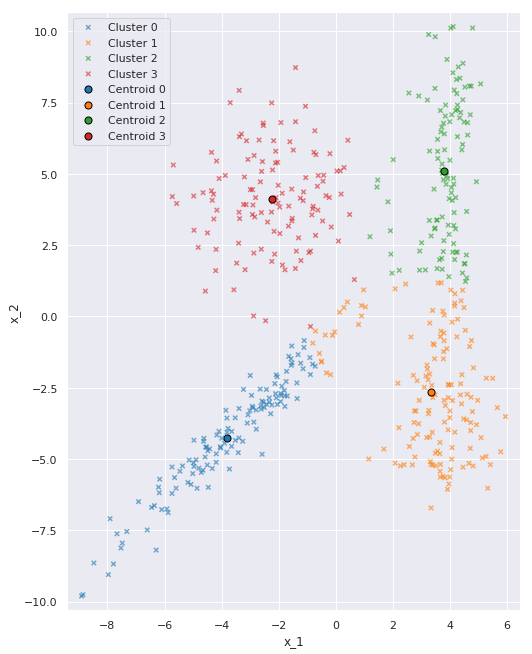

In [10]:
# Compute the associated clusters
centroids, clusters, distorsions_l = Kmeans(X);

# Display the result
figureKmeans(X, clusters, centroids)

# 4 - EM Isotropic

## 4.1 Functions to plot figures for the EM algorithm

In [11]:
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """
    Parameters
    ----------
    cov : (2, 2) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    
    
    r2 = chi2.ppf(q, 2)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

In [12]:
def ellipsoides_isotropic(mu, sigma2, ax):
    """Display 90% of the mass of the gaussian distributions contain in mu and sigma2 """

    # Parameter
    K = len(sigma2)
    n, d = np.shape(X)
    
    # Clusters
    clusters = [i for i in range(K)]
    
    # Set of colors
    cmap = cm.get_cmap("tab10") #["orange", "red", "green", "blue"]
    colors = np.array([cmap(c) for c in clusters])
    
    # Add the ellipsoide for each gaussian
    for k in range(K):
        cov = sigma2[k] * np.eye(d)
        width, height, rotation = cov_ellipse(cov, q=0.9)
        p = patches.Ellipse(xy=(mu[k,0], mu[k,1]),
                            width=width, height=height, angle=rotation, 
                            edgecolor=colors[k],
                            fill=False)
        ax.add_patch(p)

In [13]:
def attribute_clusters(q):
    """Attribute a cluster to each data point contain in gamma."""
    
    return np.argmax(q, axis=1)

In [14]:
def figure_EM(X, pi, cov, mu, q, ellipsoides_func=ellipsoides_isotropic, name="EM_Isotropic"):
    """This functions display the data point, the cluster, and the parameters of
       the gaussians of the latent variables."""
    
    # Parameter
    K = len(cov)
    n, d = np.shape(X)
    
    # Parameters of the figure
    fig, ax = plt.subplots(figsize=(11, 11))
    plt.grid(True)
    
    # Set the axes
    ax.set_xlim(X[:,0].min() - 1, X[:,0].max() + 1)
    ax.set_ylim(X[:,1].min() - 1, X[:,1].max() + 1)
    ax.set_aspect(1.0)
    
    # Attribute a cluster to each data point and display the data
    clusters = attribute_clusters(q)
    scatter(X, clusters, K, alpha=0.6)
    
    # Display the mean of the gaussians
    clusters_mu = np.array([i for i in range(K)])
    scatter(mu, clusters_mu, K, label="Center ", marker="o", s=50,
            edgecolors="black")
    
    #  Display the ellipsoide of each cluster
    ellipsoides_func(mu, cov, ax)

    # Legend of the axes
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    
    # Display the legend
    plt.legend()
    
    # Save the fig
    plt.savefig("./Images/" + name, bbox_inches='tight', pad_inches=0.0)
    
    # Display the figure
    plt.show()

## 4.2 - Functions to compute the EM algorithm in the case of isotropy

In [15]:
def objectif_isotropic(X, pi, sigma2, mu, q):
    """This function computes the value of the complete log-likelihood for the 
       given parameters."""
    
    # Parameters
    K = len(sigma2)
    n, d = np.shape(X)
    
    # Initialisation of the ojectif
    objectif = 0
    
    # Loop over each example
    for i in range(n):
        
        # Loop over each possible cluster
        for k in range(K):

            objectif = -np.log(2 * np.pi * sigma2[k])
            objectif -= 0.5 * np.sum((X[i,:] - mu[k,:])**2) / sigma2[k]
            objectif += np.log(pi[k])
            objectif *= q[i, k]
    
    return(objectif)

In [16]:
def Estep_isotropic(X, pi, sigma2, mu):
    """This function executes the M step of the EM algorithm by
       the computation of the new probabilities p(z|x)."""
    
    # Parameters
    n, d = np.shape(X)
    K = len(sigma2)
    
    # Initialisation
    argexpo = np.zeros((n, K))
    
    # Loop over each example for the computation of the probabilities
    for i in range(n):
        
        for k in range(K):
            argexpo[i,k] += -0.5 * np.sum((X[i,:] - mu[k,:])**2) / sigma2[k]
            argexpo[i,k] += np.log(pi[k]) - np.log(2 * np.pi * sigma2[k])
    
    # Computation of the maximum of each line
    maxi = np.tile(np.amax(argexpo, axis=1).reshape(n,1), (1,K))
        
    # Computation of the logarithm of q_ik
    ln_q = argexpo - maxi
    ln_q -= np.tile(np.log(np.sum(np.exp(argexpo - maxi), axis=1).reshape(n, 1)), (1, K))
    
    return np.exp(ln_q)

In [17]:
def Mstep_isotropic(X, pi, sigma2, mu, q):
    """This function executes the M step in the case of isotropic covariance matrices."""
    
    # Parameters
    K = len(sigma2)
    n, d = np.shape(X)
    
    # Estimator of mu_k
    for k in range(K):
        
        mu[k,:] = [0,0]

        for i in range(n):
            mu[k,:] += q[i,k] * X[i,:]
            
        mu[k,:] /= np.sum(q[:,k])
    
    # Estimator of sigma2_k
    for k in range(K):
        
        sigma2[k] = 0
        
        for i in range(n):
            sigma2[k] += q[i,k] * np.sum((X[i,:] - mu[k,:])**2)
            
        sigma2[k] /= d * np.sum(q[:,k])
        
    # Estimator of pi_k
    pi = np.sum(q, axis=0)
    pi /= np.sum(pi)
    
    # Return results
    return pi, sigma2, mu

In [18]:
def EM_isotropic(X,  centroids, K=4):
    """This function executes the EM algorithm in the case of istropic covariance matrices."""
    
    # Parameters
    n, d = np.shape(X)
    
    # Initialisation of the probabilities
    q = np.random.rand(n, K)
    for i in range(n):
        q[i,:] /= np.sum(q[i,:])
    
    # Initialisation of the parameters for the E step
#     clusters = [0 for i in range(K)]
#     while max(clusters) != K - 1:
#         mu, clusters, distor = Kmeans(X, K=K)
    mu = centroids
    
    # Initialisation of the matrix of covariance
    sigma2 = np.ones(K)
    
    # Initialisation of the parameters for the M step
    pi = np.random.rand(K)
    pi /= np.sum(pi)
    
    # Initialisation of the objectif
    objectif_new = objectif_isotropic(X, pi, sigma2, mu, q)
    objectif_old = 2 * objectif_new
    
    while (abs((objectif_old-objectif_new)/objectif_old)>10e-7):
        
        # E step
        q = Estep_isotropic(X, pi, sigma2, mu)
        
        # M step
        pi, sigma2, mu = Mstep_isotropic(X, pi, sigma2, mu, q)
        
        # Update of the objectif function
        objectif_old = objectif_new
        objectif_new = objectif_isotropic(X, pi, sigma2, mu, q)
        
    return(pi, sigma2, mu, q)

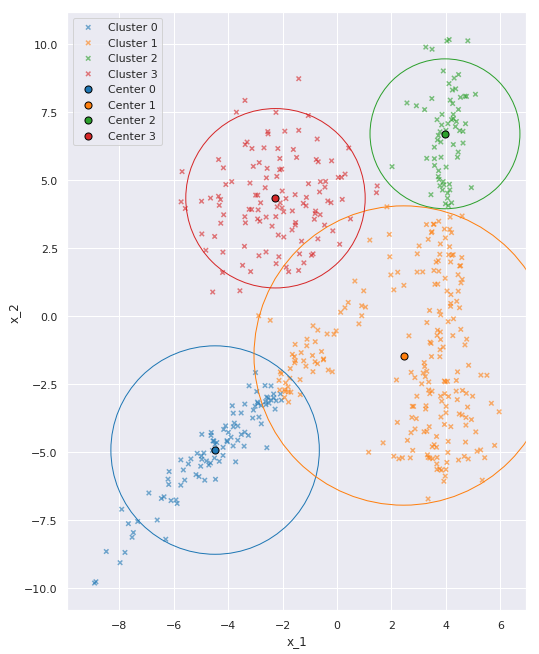

In [19]:
# Computing of the different parameters by means of the Em Isotropic
(pi_iso, sigma2_iso, mu_iso, q_iso) = EM_isotropic(X, centroids)

# Display the different clusters
figure_EM(X, pi_iso, sigma2_iso, mu_iso, q_iso)

# 5 - EM for general covariance matrices

## 5.1 - Graphic Functions

In [20]:
def ellipsoides_general(mu, cov, ax):
    """Display 90% of the mass of the gaussian distributions contain in mu and sigma2 """

    # Parameter
    K = len(cov)
    n, d = np.shape(X)
    
    # Clusters
    clusters = [i for i in range(K)]
    
    # Set of colors
    cmap = cm.get_cmap("tab10") #["orange", "red", "green", "blue"]
    colors = np.array([cmap(c) for c in clusters])
    
    # Add the ellipsoide for each gaussian        
    for k in range(K):
        width, height, rotation = cov_ellipse(cov[k,:,:], q=0.9)
        p = patches.Ellipse(xy=(mu[k,0], mu[k,1]),
                            width=width, height=height, angle=rotation, 
                            edgecolor=colors[k],
                            fill=False)
        ax.add_patch(p)

## 5.2 - Algorithmic functions

In [21]:
def generate_cov(d=2, K=4):
    """Generate random covariance matrices."""
    
    # Initialisation of the random matrices
    cov = np.zeros((K, d, d))
    
    for k in range(K):
        P = np.random.rand(d, d)
        Q, R = np.linalg.qr(P)
        cov[k,:,:] = np.dot(Q, np.dot(np.diag(np.random.rand(d) +1 ), np.transpose(Q)))
        
    return cov

In [22]:
def objectif(X, pi, cov, mu, q):
    """This function computes the complete-log-likelihood for the given parameters."""
    
    # Parameters
    K = len(pi)
    n, d = np.shape(X)
    
    # Initialisation of the value of the objectif function
    objectif = 0
    
    # Loop over each data point
    for i in range(n):
        for k in range(K):
            
            y = X[i,:] - mu[k,:]
            inv = np.linalg.inv(cov[k,:,:])
            
            objectif -= 0.5 * np.dot(y, np.dot(inv, y))
            objectif -= np.log(2 * np.pi * np.sqrt(np.linalg.det(cov[k,:,:])))
            objectif += np.log(pi[k])
            objectif *= q[i,k]
    
    return objectif

In [23]:
def Estep(X, pi, cov, mu):
    """This function executes the E step for general matrices"""
    
    # Parameters
    n, d = np.shape(X)
    K = len(pi)
    
    # Initialisation
    argexpo = np.zeros((n,K))
    
    for i in range(n):
        for k in range(K):
            
            y = X[i,:] - mu[k,:]
            inv = np.linalg.inv(cov[k,:,:])
            
            argexpo[i,k] -= 0.5 * np.dot(y, np.dot(inv, y))
            argexpo[i,k] += np.log(pi[k])
            argexpo[i,k] -= np.log(2 * np.pi * np.sqrt(np.linalg.det(cov[k,:,:])))
    
    # Computation of the max argexpo for each data point i
    maxi = np.tile(np.amax(argexpo, axis=1).reshape(n, 1), (1, K))
    
    # Computation of the logarithm of q_ik
    ln_q = argexpo - maxi
    ln_q -= np.tile(np.log(np.sum(np.exp(argexpo - maxi),axis=1).reshape(n, 1)), (1, K))
    
    return np.exp(ln_q)

In [24]:
def Mstep(X, pi, cov, mu, q):
    """This function executes the M step of the EM algorithm for general covariance
       matrices."""
    
    # Parameters
    K = len(pi)
    n, d = np.shape(X)
    
    # Estimator of mu_k
    for k in range(K):
        
        mu[k,:] = [0,0]
        
        for i in range(n):
            mu[k,:] += q[i,k] * X[i,:]
            
        mu[k,:] /= np.sum(q[:,k])
    
    # Estimator of sigma2_k
    for k in range(K):
        
        cov[k,:,:] = np.zeros((d,d))
        
        for i in range(n):
            
            y = (X[i,:] - mu[k,:]).reshape(d, 1)     
            cov[k,:,:] += q[i,k] * np.dot(y, y.T)

        cov[k,:,:] /= np.sum(q[:,k])
        
        # Regularisation for avoiding null matrices.
        cov[k,:,:] += 0.001 * np.eye(d)

    # Estimator of pi_k
    pi = np.sum(q, axis=0)
    pi /= np.sum(pi)
    
    # Return results
    return pi, cov, mu

In [25]:
def EM(X, centroids, K=4):
    """This function executes the EM algorithm."""
    
    # Parameters
    n, d = np.shape(X)
    
    # Initialisation of the latent probabilities
    q = np.random.rand(n, K) 
    for i in range(n):
        q[i,:] /= np.sum(q[i,:]) 
        
    # Initialisation of the parameters for the E step
    cov = generate_cov(d, K)
#     clusters = [0 for i in range(K)]
#     while max(clusters) != K - 1:
#         mu, clusters, distor = Kmeans(X, K=K)
    mu = centroids
    pi = np.random.rand(K)
    pi /= np.sum(pi)
    
    # Initialisation of the objectif
    objectif_new = objectif(X, pi, cov, mu, q)
    objectif_old = 2 * objectif_new
    
    while abs((objectif_old - objectif_new) / objectif_old) > 10e-7:
        
        # E step
        q = Estep(X, pi, cov, mu)
        
        # M step
        pi, cov, mu = Mstep(X, pi, cov, mu, q)
        
        # Update of the objectif
        objectif_old = objectif_new
        objectif_new = objectif(X, pi, cov, mu, q)
        
    return pi, cov, mu, q

In [26]:
# Execute the EM algorithm and compute the parameters
pi, cov, mu, q = EM(X, centroids)

In [32]:
np.save("mu_TP2",np.array(mu))
np.save("cov_TP2",np.array(cov))
np.save("q_TP2",np.array(q))

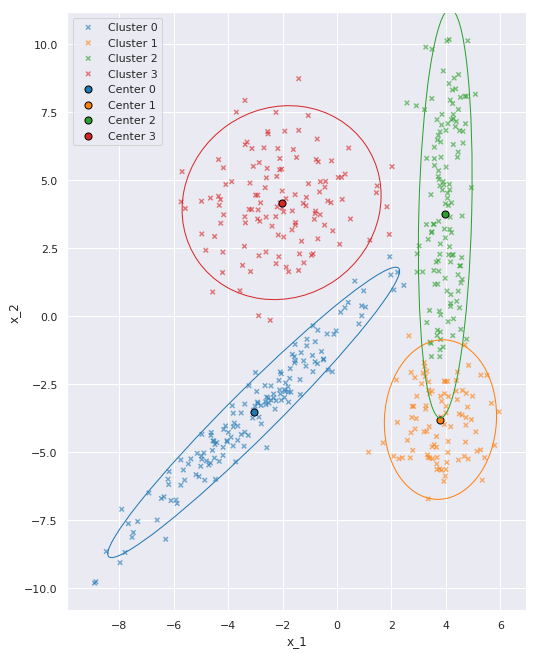

In [28]:
# Display the results
figure_EM(X, pi, cov, mu, q, ellipsoides_func=ellipsoides_general, name="EM_General")

# 6 - Comparison of the log-likelihoods of the two mixture models on the training data, as well as on test data

In [29]:
# Computation of 
q_test_iso = Estep_isotropic(X_test, pi_iso, sigma2_iso, mu_iso)
q_test = Estep(X_test, pi, cov, mu)

In [30]:
# Computation of the log-likelihood in the case of isotropy
obj_train_iso = objectif_isotropic(X, pi_iso, sigma2_iso, mu_iso, q_iso)
obj_test_iso = objectif_isotropic(X_test, pi_iso, sigma2_iso, mu_iso, q_test_iso)

# Computation of the log-likelihood in the general case
obj_train = objectif(X, pi, cov, mu, q)
obj_test = objectif(X_test, pi, cov, mu, q_test)

In [31]:
# Parameters
n, d = np.shape(X)
n_test, d = np.shape(X_test)

# Display the results
print("                          LOG-LIKELIHOOD/Number of data")
print("\n")
print("                    TRAIN                        TEST")
print("ISOTROPIC   ", obj_train_iso / n, "         ", obj_test_iso / n_test)
print("GENERAL CASE", obj_train / n, "          ", obj_test / n_test)

                          LOG-LIKELIHOOD/Number of data


                    TRAIN                        TEST
ISOTROPIC    -2.34584090147143e-05           -2.1080756561998942e-10
GENERAL CASE -1.298853227641707e-05            -9.634152056474961e-10
